In [1]:
# 3rd party dependencies
from deepface import DeepFace
import tenseal as ts
import cv2
import matplotlib.pyplot as plt
import pytest

# project dependencies
import utils

In [2]:
context = ts.context_from(utils.read_data("public.txt"))

# Scan a Face on Edge Device

In [3]:
# https://sefiks.com/wp-content/uploads/2020/09/target.jpg
# notice that this is not available in my facial database even though another image of angelina is there
target_path = "../../target.jpg"

In [4]:
target_img = cv2.imread(target_path)

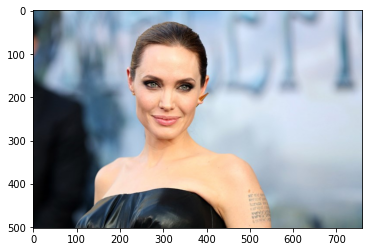

In [5]:
plt.imshow(target_img[:,:,::-1])

In [6]:
target_embedding = DeepFace.represent(target_path, model_name="Facenet")[0]["embedding"]

In [7]:
print(f"model generated {len(target_embedding)} dimensional vector for target image")

model generated 128 dimensional vector for target image


In [8]:
# encrypt target image's embedding with public key
target_encrypted_embedding = ts.ckks_vector(context, target_embedding)

In [9]:
identity = "angelina"

In [10]:
# read angelina's pre-calculated encrypted embedding
source_encrypted_embedding_proto = utils.read_data(f"database/{identity}.txt")
source_encrypted_embedding = ts.lazy_ckks_vector_from(source_encrypted_embedding_proto)
source_encrypted_embedding.link_context(context)

In [11]:
# cloud mustn't able to decrypt the embedding
with pytest.raises(ValueError, match="current context of the tensor doesn't hold a secret_key"):
    source_encrypted_embedding.decrypt()[0]

# Calculate Encrypted Euclicdean Distance Squared

<img src="figures/euclidean_distance.svg"/>

In [12]:
# but it still can do homomorphic operations

# find the difference of each dimension
euclidean_squared = source_encrypted_embedding - target_encrypted_embedding

# find squared values of each dimension and sum them
euclidean_squared = euclidean_squared.dot(euclidean_squared)

# squared root is not defined in homomorphic encryption
# so, result is euclidean distance squared instead of euclidean distance

In [14]:
utils.write_data("database/target_euclidean_squared.txt", euclidean_squared.serialize())